# 1. LSTM Script

1 Script: Training, Validation und Test

Loaded MGFarm_18650_C01
Total train/val sample size: 17167
Training set size: 13733
Validation set size: 3434
Test set size: 17167


/tmp/ipykernel_1373231/2844242876.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_val.loc[:, 'timestamp'] = pd.to_datetime(df_train_val['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
/tmp/ipykernel_1373231/2844242876.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'timestamp'] = pd.to_datetime(df_test['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])


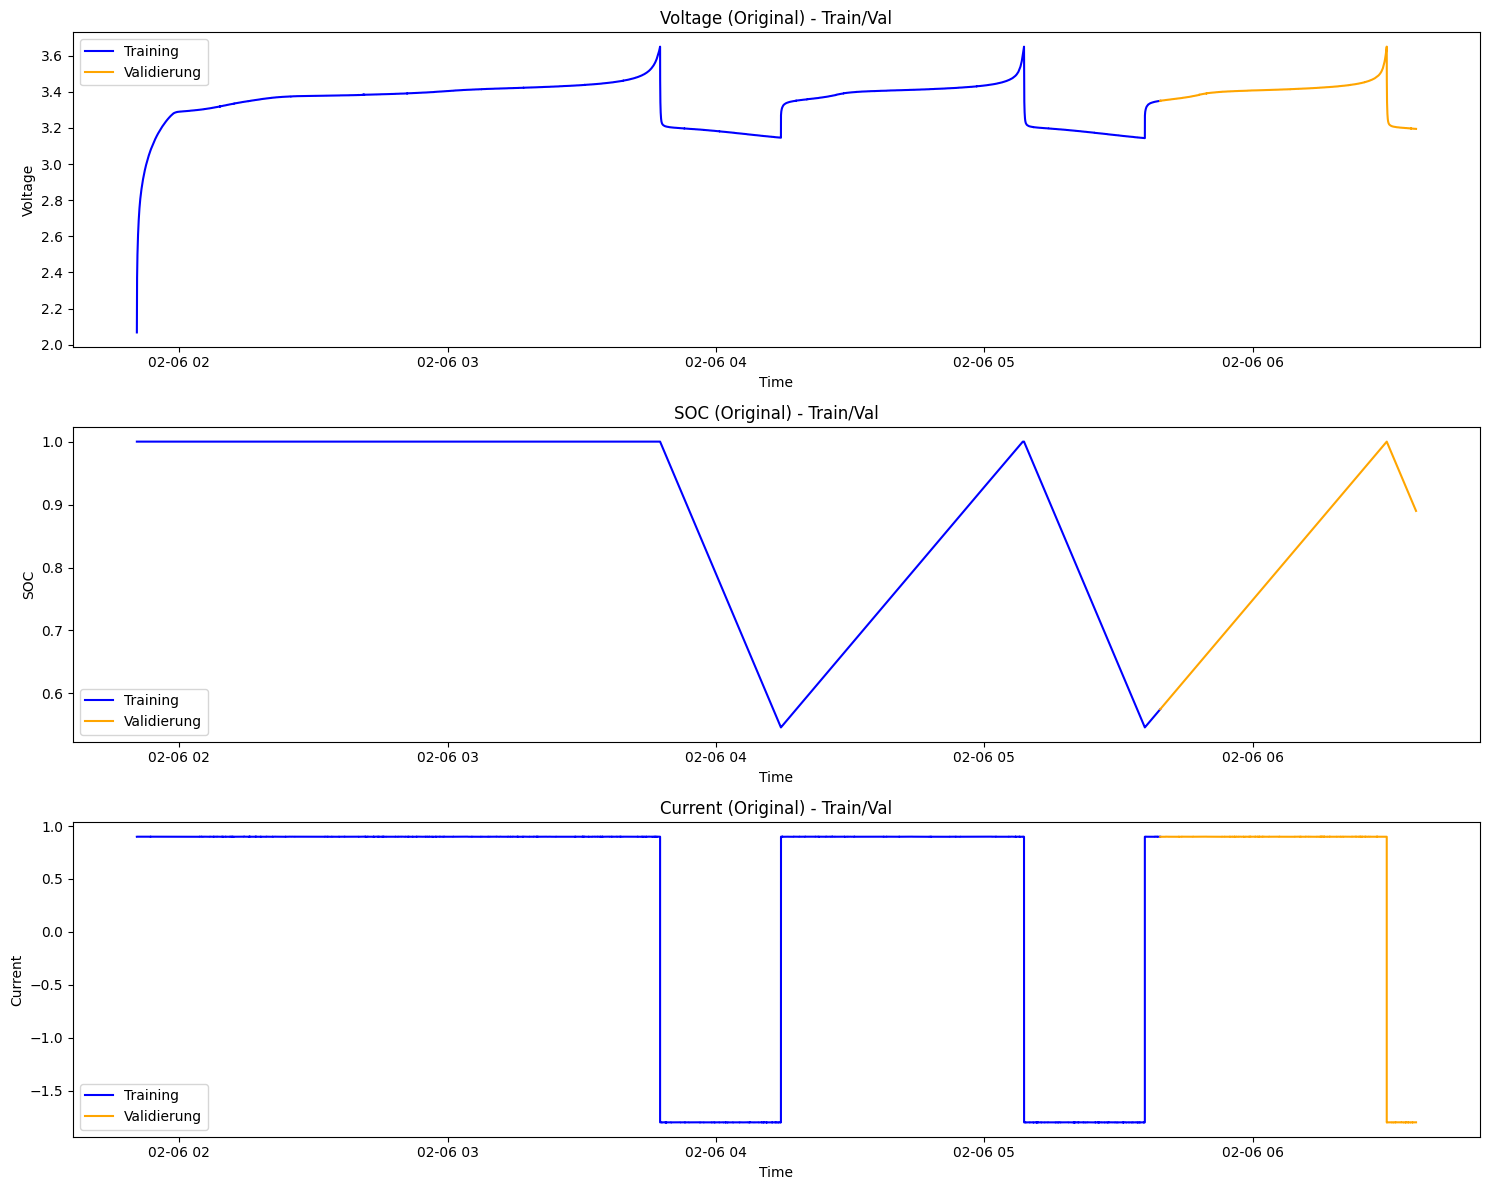

Epoch [1/20] - Train MSE: 0.0519
Epoch [2/20] - Train MSE: 0.0000
Epoch [3/20] - Train MSE: 0.0000
Epoch [4/20] - Train MSE: 0.0000
Epoch [5/20] - Train MSE: 0.0000
Epoch [6/20] - Train MSE: 0.0000
Epoch [7/20] - Train MSE: 0.0000
Epoch [8/20] - Train MSE: 0.0000
Epoch [9/20] - Train MSE: 0.0000
Epoch [10/20] - Train MSE: 0.0000
Epoch [11/20] - Train MSE: 0.0000
Epoch [12/20] - Train MSE: 0.0000
Epoch [13/20] - Train MSE: 0.0000
Epoch [14/20] - Train MSE: 0.0000
Epoch [15/20] - Train MSE: 0.0000
Epoch [16/20] - Train MSE: 0.0000
Epoch [17/20] - Train MSE: 0.0000
Epoch [18/20] - Train MSE: 0.0000
Epoch [19/20] - Train MSE: 0.0000
Epoch [20/20] - Train MSE: 0.0000


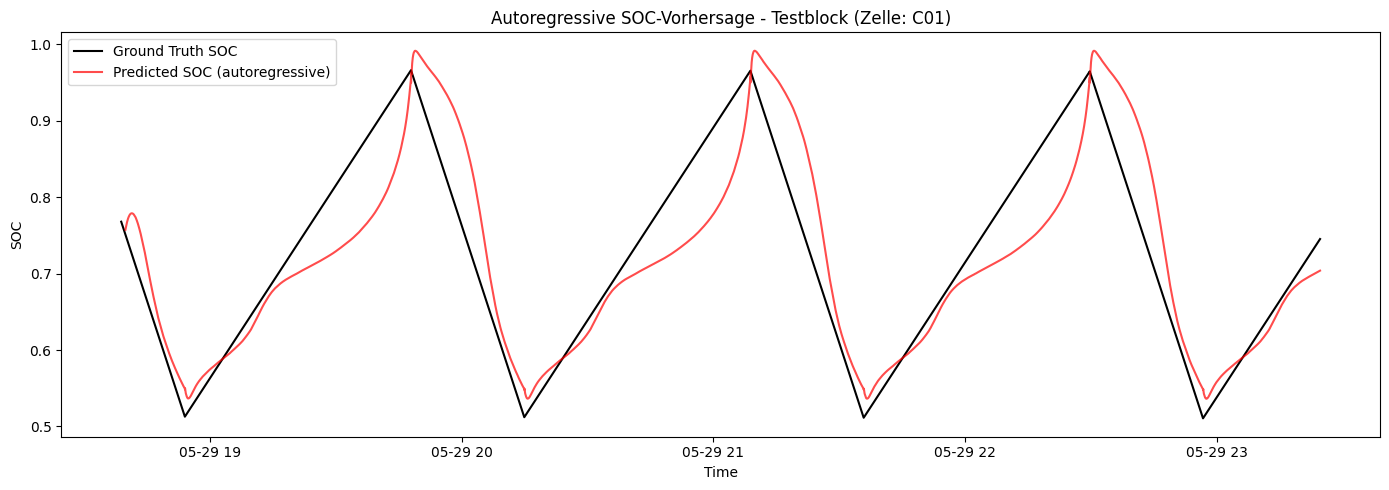

In [10]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import torch

# Ändere load_cell_data: suche alle Unterordner, die mit "MGFarm_18650_C" beginnen, und extrahiere den Zellnamen
def load_cell_data(data_dir: Path):
    """Lade nur die df.parquet aus dem Unterordner 'MGFarm_18650_C01'.
       Der Schlüssel im Rückgabedict ist der Zellname (z.B. 'C01')."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

# Lade alle verfügbaren Zell-Dataframes
data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)

# Verwende nur die erste Zelle
cell_keys = sorted(cell_data.keys())[:1]  # z.B. ['C01']
if len(cell_keys) < 1:
    raise ValueError("Es wurde keine Zelle gefunden; bitte prüfen.")

train_cell = cell_keys[0]  # z.B. 'C01'
df_full = cell_data[train_cell]

# Neue Version: 0.1% der Daten für Training/Validierung und ein mittlerer Block als Test
sample_size = int(len(df_full) * 0.001)
df_train_val = df_full.head(sample_size)
mid_start = (len(df_full) - sample_size) // 2
df_test = df_full.iloc[mid_start : mid_start + sample_size]

# Convert timestamp to datetime und lege neue Spalte an (für train/val)
df_train_val.loc[:, 'timestamp'] = pd.to_datetime(df_train_val['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_train_val_orig = df_train_val.copy()

# Konvertiere auch den Test-Datensatz
df_test.loc[:, 'timestamp'] = pd.to_datetime(df_test['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_test_orig = df_test.copy()

# Neues Split in Training (80%) und Validierung (20%) aus df_train_val
total = len(df_train_val)
train_cut = int(total * 0.8)
train_data_orig = df_train_val_orig.iloc[:train_cut]
val_data_orig   = df_train_val_orig.iloc[train_cut:]

# Skalierung nur für die Modell-Daten (SOC_ZHU wird NICHT skaliert)
scaler = StandardScaler()
features = ['Voltage[V]', 'Current[A]']  # Nur Voltage & Current skalieren
train_data = df_train_val.iloc[:train_cut].copy()
val_data   = df_train_val.iloc[train_cut:].copy()
train_data[features] = scaler.fit_transform(train_data[features])
val_data[features]   = scaler.transform(val_data[features])
test_data = df_test.copy()
test_data[features]  = scaler.transform(test_data[features])

print(f"Total train/val sample size: {total}")
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Plot Original-Werte (Train/Val)
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.plot(train_data_orig['timestamp'], train_data_orig['Voltage[V]'], 'b-', label='Training')
plt.plot(val_data_orig['timestamp'], val_data_orig['Voltage[V]'], 'orange', label='Validierung')
plt.title('Voltage (Original) - Train/Val')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_data_orig['timestamp'], train_data_orig['SOC_ZHU'], 'b-', label='Training')
plt.plot(val_data_orig['timestamp'], val_data_orig['SOC_ZHU'], 'orange', label='Validierung')
plt.title('SOC (Original) - Train/Val')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_data_orig['timestamp'], train_data_orig['Current[A]'], 'b-', label='Training')
plt.plot(val_data_orig['timestamp'], val_data_orig['Current[A]'], 'orange', label='Validierung')
plt.title('Current (Original) - Train/Val')
plt.xlabel('Time')
plt.ylabel('Current')
plt.legend()
plt.tight_layout()
plt.show()

################################################################################
# >>>>> NEUER ABSCHNITT: Autoregressives LSTM (kein TFT) <<<<<
################################################################################

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1) Vorbereiten: Wir fassen train+val zusammen zu einem einzigen Trainings-Dataset,
#    weil Du in der Regel "Validation" für Tuning brauchst. Aber hier machen wir's einfach:
df_trainval = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)
df_test_    = test_data.reset_index(drop=True)

# 2) Erstelle numpy-Arrays: [Voltage, Current, SOC]
#    => Voltage/Current sind skaliert, SOC unskaliert
trainval_array = df_trainval[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values
test_array     = df_test_[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values

# Wir verwenden seq_length=60 => LSTM sieht 60 aufeinanderfolgende Steps,
# und lernt, den SOC im nächsten Schritt (t+1) vorherzusagen
seq_length = 60

class SequenceDataset(Dataset):
    """
    Gibt (seq, next_value) zurück, d.h. 
      X[t] = (Voltage[t], Current[t], SOC[t])  (über seq_length Timesteps)
      y[t] = SOC[t+1].
    """
    def __init__(self, data_array, seq_len=60):
        self.data_array = data_array
        self.seq_len = seq_len

    def __len__(self):
        # Letzter Index: wir brauchen (t+seq_len) + 1 <= len
        return len(self.data_array) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.data_array[idx : idx + self.seq_len]  # shape (seq_len, 3)
        y_val = self.data_array[idx + self.seq_len, 2]     # Spalte 2 = SOC
        x_seq_t = torch.tensor(x_seq, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32)
        return x_seq_t, y_val_t

trainval_dataset = SequenceDataset(trainval_array, seq_len=seq_length)
test_dataset     = SequenceDataset(test_array,     seq_len=seq_length)

trainval_loader = DataLoader(trainval_dataset, batch_size=32, shuffle=True)
test_loader     = DataLoader(test_dataset,     batch_size=32, shuffle=False)

# 3) Definiere ein einfaches LSTM-Modell
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x.shape = (batch_size, seq_length, input_size=3)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # letzer Zeitschritt im Output:
        last_out = lstm_out[:, -1, :]  # shape = (batch_size, hidden_size)
        soc_pred = self.fc(last_out)   # shape = (batch_size, 1)
        return soc_pred.squeeze(-1)    # -> (batch_size,)

model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 4) Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_losses = []
    for x_batch, y_batch in trainval_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}] - Train MSE: {np.mean(train_losses):.4f}")

# 5) Autoregressive Vorhersage auf dem Test-Block
#    (Rollt Schritt für Schritt durch, nutzt KEIN Ground Truth im Test)
def predict_autoregressive(model, data_array, seq_len=60):
    """
    Nutzt das erste seq_len-Fenster "wie gehabt" (die echten SOC-Werte),
    ab dann wird der SOC[t+1] durch Modell ersetzt.
    
    data_array: shape (N, 3) -> [Voltage, Current, SOC]
    Wir überschreiben SOC[t+1] in data_clone, 
    so dass SOC ab Step seq_len rein vom Modell kommt.
    """
    model.eval()
    data_clone = data_array.copy()
    preds = np.full(len(data_clone), np.nan)

    with torch.no_grad():
        # Start ab Index seq_len
        for i in range(seq_len, len(data_clone)):
            # Baue Eingabefenster [i-seq_len : i]
            input_seq = data_clone[i-seq_len : i]  # (seq_len, 3)
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # shape (1, seq_len, 3)
            
            # Vorhersage
            pred_soc = model(x_t).item()
            
            preds[i] = pred_soc
            # Autoregressiv: Überschreibe den SOC in data_clone (Spalte 2)
            data_clone[i, 2] = pred_soc

    return preds

preds_test = predict_autoregressive(model, test_array, seq_len=seq_length)

# 6) Plot: Ground Truth vs. Prediction im Testbereich
gt_test = test_array[:, 2]  # unskalierter SOC
time_test = df_test_orig['timestamp'].values  # Original-Timestamps im Testblock

plt.figure(figsize=(14, 5))
plt.plot(time_test, gt_test, label="Ground Truth SOC", color='k')
plt.plot(time_test, preds_test, label="Predicted SOC (autoregressive)", color='r', alpha=0.7)
plt.title(f"Autoregressive SOC-Vorhersage - Testblock (Zelle: {train_cell})")
plt.xlabel("Time")
plt.ylabel("SOC")
plt.legend()
plt.tight_layout()
plt.show()


# 2. LSTM - Script: 
Training und Testing getrennt

## 2. LSTM - Training

In [ ]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib  # zum Speichern des Scalers

###############################################################################
# 1) Daten laden wie gehabt
###############################################################################
def load_cell_data(data_dir: Path):
    """Lade nur die df.parquet aus dem Unterordner 'MGFarm_18650_C01'.
       Der Schlüssel im Rückgabedict ist der Zellname (z.B. 'C01')."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)
cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

train_cell = cell_keys[0]
df_full = cell_data[train_cell]

# 0.1% für Training+Val, mittlerer Block als Test (wie in Deinem Original)
sample_size = int(len(df_full) * 0.01)
df_train_val = df_full.head(sample_size)
mid_start = (len(df_full) - sample_size) // 2
df_test = df_full.iloc[mid_start : mid_start + sample_size]

# Zeitstempel konvertieren
df_train_val.loc[:, 'timestamp'] = pd.to_datetime(df_train_val['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_train_val_orig = df_train_val.copy()

df_test.loc[:, 'timestamp'] = pd.to_datetime(df_test['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_test_orig = df_test.copy()

# Aufteilen in Training (80%) + Val (20%)
total = len(df_train_val)
train_cut = int(total * 0.8)
train_data_orig = df_train_val_orig.iloc[:train_cut]
val_data_orig   = df_train_val_orig.iloc[train_cut:]

###############################################################################
# 2) Skalierung
###############################################################################
scaler = StandardScaler()
features = ['Voltage[V]', 'Current[A]']

train_data = df_train_val.iloc[:train_cut].copy()
val_data   = df_train_val.iloc[train_cut:].copy()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features]   = scaler.transform(val_data[features])

# Testdaten werden ebenso transformiert
test_data = df_test.copy()
test_data[features]  = scaler.transform(test_data[features])

print(f"Total train/val sample size: {total}")
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Optional: ein kurzes Plot (Train/Val)
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.plot(train_data_orig['timestamp'], train_data_orig['Voltage[V]'], 'b-', label='Training')
plt.plot(val_data_orig['timestamp'], val_data_orig['Voltage[V]'], 'orange', label='Validierung')
plt.title('Voltage (Original) - Train/Val')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_data_orig['timestamp'], train_data_orig['SOC_ZHU'], 'b-', label='Training')
plt.plot(val_data_orig['timestamp'], val_data_orig['SOC_ZHU'], 'orange', label='Validierung')
plt.title('SOC (Original) - Train/Val')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_data_orig['timestamp'], train_data_orig['Current[A]'], 'b-', label='Training')
plt.plot(val_data_orig['timestamp'], val_data_orig['Current[A]'], 'orange', label='Validierung')
plt.title('Current (Original) - Train/Val')
plt.xlabel('Time')
plt.ylabel('Current')
plt.legend()
plt.tight_layout()
plt.show()

###############################################################################
# 3) Daten für LSTM (train+val + test). Wir trainieren NUR auf train+val
###############################################################################
df_trainval = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)
df_test_    = test_data.reset_index(drop=True)

trainval_array = df_trainval[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values
test_array     = df_test_[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values

seq_length = 60

class SequenceDataset(Dataset):
    def __init__(self, data_array, seq_len=60):
        self.data_array = data_array
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data_array) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.data_array[idx : idx + self.seq_len]
        y_val = self.data_array[idx + self.seq_len, 2]  # Spalte 2 = SOC
        x_seq_t = torch.tensor(x_seq, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32)
        return x_seq_t, y_val_t

trainval_dataset = SequenceDataset(trainval_array, seq_len=seq_length)
trainval_loader  = DataLoader(trainval_dataset, batch_size=32, shuffle=True)

###############################################################################
# 4) LSTM-Modell definieren & trainieren
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)

model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 20
for epoch in range(epochs):
    model.train()
    train_losses = []
    for x_batch, y_batch in trainval_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}] - Train MSE: {np.mean(train_losses):.6f}")

###############################################################################
# 5) Speichere Modell & Scaler
###############################################################################
os.makedirs("models", exist_ok=True)

model_save_path = "models/lstm_soc_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Gespeichertes LSTM-Modell: {model_save_path}")

scaler_save_path = "models/scaler.pkl"
joblib.dump(scaler, scaler_save_path)
print(f"Gespeicherter Scaler: {scaler_save_path}")


## 2. LSTM:  Test 
Prediction (nur anfang ground truht)

Loaded MGFarm_18650_C01
Geladener Scaler: models/scaler.pkl
Geladenes LSTM-Modell: models/lstm_soc_model.pth


/tmp/ipykernel_1373231/3523806192.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'timestamp'] = pd.to_datetime(df_test['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
/tmp/ipykernel_1373231/3523806192.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be a

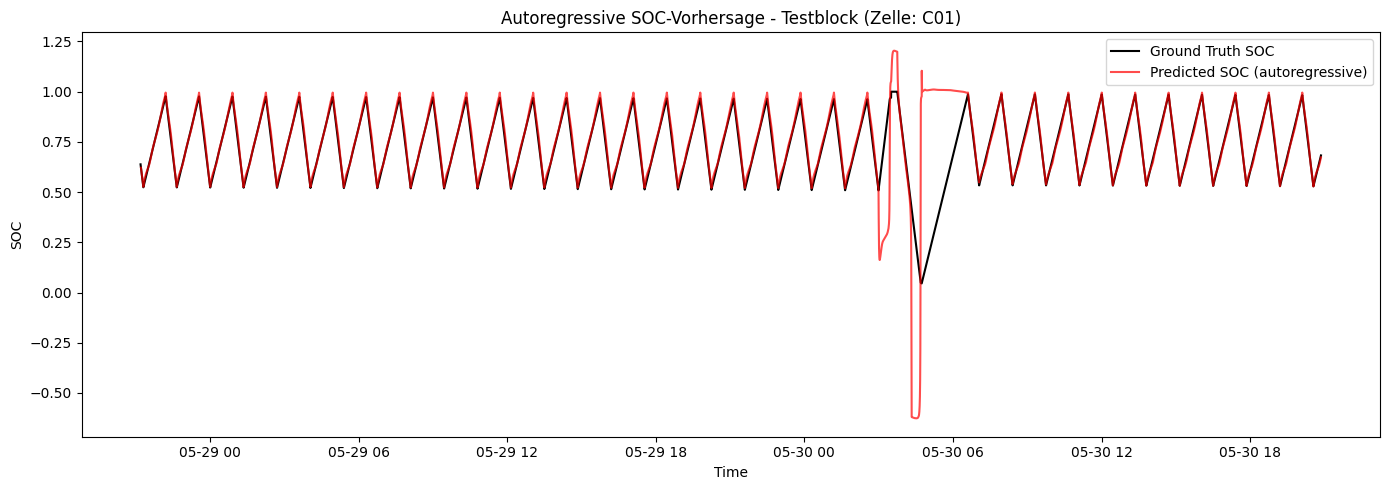

In [5]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib

###############################################################################
# 1) Gleicher Datensatz laden und identisch aufbereiten
###############################################################################
def load_cell_data(data_dir: Path):
    """Wie gehabt: MGFarm_18650_C01."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)
cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

train_cell = cell_keys[0]
df_full = cell_data[train_cell]

# Dieselbe Aufteilung
sample_size = int(len(df_full) * 0.01)
df_train_val = df_full.head(sample_size)
mid_start = (len(df_full) - sample_size) // 2
df_test = df_full.iloc[mid_start : mid_start + sample_size]

df_test.loc[:, 'timestamp'] = pd.to_datetime(df_test['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_test_orig = df_test.copy()

# Skaliere mit DEMSELBEN Scaler
scaler_path = "models/scaler.pkl"
scaler = joblib.load(scaler_path)
print(f"Geladener Scaler: {scaler_path}")

features = ['Voltage[V]', 'Current[A]']
test_data = df_test.copy()
test_data[features] = scaler.transform(test_data[features])

df_test_ = test_data.reset_index(drop=True)
test_array = df_test_[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values

###############################################################################
# 2) Gleiche Modell-Definition + Laden des state_dict
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)

model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1)
model_load_path = "models/lstm_soc_model.pth"
model.load_state_dict(torch.load(model_load_path))
model.eval()
print(f"Geladenes LSTM-Modell: {model_load_path}")

###############################################################################
# 3) Autoregressive Vorhersage
###############################################################################
def predict_autoregressive(model, data_array, seq_len=60):
    model.eval()
    data_clone = data_array.copy()
    preds = np.full(len(data_clone), np.nan)
    with torch.no_grad():
        for i in range(seq_len, len(data_clone)):
            input_seq = data_clone[i-seq_len : i]
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            data_clone[i, 2] = pred_soc
    return preds

seq_length = 60
preds_test = predict_autoregressive(model, test_array, seq_len=seq_length)

###############################################################################
# 4) Plot
###############################################################################
gt_test = test_array[:, 2]  # SOC
time_test = df_test_orig['timestamp'].values

plt.figure(figsize=(14, 5))
plt.plot(time_test, gt_test, label="Ground Truth SOC", color='k')
plt.plot(time_test, preds_test, label="Predicted SOC (autoregressive)", color='r', alpha=0.7)
plt.title(f"Autoregressive SOC-Vorhersage - Testblock (Zelle: {train_cell})")
plt.xlabel("Time")
plt.ylabel("SOC")
plt.legend()
plt.tight_layout()
plt.show()


# 2. LSTM - Test
mit Anfangs SOC als vorgabe

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

###############################################################################
# 1) Hilfsfunktionen und Modell-Definition
###############################################################################
def load_cell_data(data_dir: Path):
    """MGFarm_18650_C01 laden."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out).squeeze(-1)

###############################################################################
# 2) Autoregressive Vorhersage-Funktion OHNE Ground Truth
###############################################################################
def predict_autoregressive_no_gt(model, voltage_current_array, 
                                 seq_len=60, initial_soc=0.5):
    """
    Rein autoregressiv, KEIN Ground Truth:
    - 'voltage_current_array' = numpy mit shape (N,2) => [Voltage, Current]
    - Wir bauen uns ein data_clone in shape (N,3) => (Voltage, Current, SOC)
      und setzen SOC überall (!) auf NaN.
    - Die ersten seq_len Zeitschritte füllen wir mit 'initial_soc'.
      Ab dann wird SOC[t] immer vom Modell predicted.
    """
    model.eval()
    N = len(voltage_current_array)
    data_clone = np.zeros((N, 3), dtype=np.float32)
    data_clone[:, :2] = voltage_current_array  # Voltage, Current
    data_clone[:, 2]  = np.nan                 # SOC erstmal weglassen

    # SOC in den ersten 'seq_len' Zeitschritten auf den Startwert setzen:
    data_clone[:seq_len, 2] = initial_soc

    preds = np.full(N, np.nan, dtype=np.float32)

    with torch.no_grad():
        # Los geht's ab i=seq_len
        for i in range(seq_len, N):
            # Inputfenster = data_clone[i-seq_len : i] => shape (seq_len, 3)
            window = data_clone[i-seq_len : i]
            x_t = torch.tensor(window, dtype=torch.float32).unsqueeze(0) # (1, seq_len, 3)
            
            pred_soc = model(x_t).item()
            data_clone[i, 2] = pred_soc  # Autoregressiv => Modell-Output als SOC
            preds[i] = pred_soc

        # Auch die ersten seq_len Indizes (0 ... seq_len-1) kannst Du im Plot
        # zeigen => dort ist der SOC = 'initial_soc' = reiner Annahme-Wert.
        preds[:seq_len] = initial_soc

    return preds

###############################################################################
# 3) Lade Daten (z.B. dieselbe "df_full"), wähle *beliebiges* Zeitfenster
###############################################################################
data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)
cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

train_cell = cell_keys[0]
df_full = cell_data[train_cell].copy()
df_full["timestamp"] = pd.to_datetime(df_full['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])

###############################################################################
# ---> Stelle hier Deinen Testabschnitt ein <---
# z.B. nimm Index 500 bis 1500:
###############################################################################
test_start = 50000
test_end   = 100000
df_test = df_full.iloc[test_start : test_end].copy()
df_test.reset_index(drop=True, inplace=True)

###############################################################################
# 4) Lade Scaler (vom Training) und transformiere NUR Voltage/Current
###############################################################################
scaler_path = "models/scaler.pkl"
scaler = joblib.load(scaler_path)
print(f"Scaler geladen von: {scaler_path}")

voltage_current = df_test[["Voltage[V]", "Current[A]"]].values
voltage_current_scaled = scaler.transform(voltage_current)  # shape (N,2)

###############################################################################
# 5) Lade das trainierte LSTM-Modell
###############################################################################
model_path = "models/lstm_soc_model.pth"
model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1)
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Modell geladen von: {model_path}")

###############################################################################
# 6) Rein autoregressiv vorhersagen (OHNE Ground Truth) 
#    => Du kannst hier 'initial_soc' anpassen, z.B. 0.6, etc.
###############################################################################
seq_length = 60
initial_soc = 0.5

preds = predict_autoregressive_no_gt(
    model,
    voltage_current_scaled,  
    seq_len=seq_length,
    initial_soc=initial_soc
)

###############################################################################
# 7) Plotten
###############################################################################
time_test = df_test["timestamp"].values
gt_test   = df_test["SOC_ZHU"].values  # Nur zum Anzeigen, NICHT genutzt im Modell

plt.figure(figsize=(12,5))
plt.plot(time_test, gt_test, label="Ground Truth SOC", color='k')
plt.plot(time_test, preds, label="Predicted SOC (autoregressive, no GT)", color='r')
plt.title(f"Autoregressive SOC-Vorhersage - Kein Ground Truth (Zelle: {train_cell})")
plt.xlabel("Time")
plt.ylabel("SOC")
plt.legend()
plt.tight_layout()
plt.show()


Loaded MGFarm_18650_C01


KeyboardInterrupt: 

# 3. LSTM - Script
Kfold + random Split

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
import joblib

###############################################################################
# ----------------------------- KONFIGURATION ----------------------------------
###############################################################################
DATA_DIR = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
CELL_NAMES = ["C01"]   # Du kannst hier mehrere Zellen angeben, oder nur "C01"
CHUNK_PERCENT = 0.01   # 1% pro Chunk
EPOCHS_PER_CHUNK = 5
BATCH_SIZE = 64
SEQ_LENGTH = 60
HIDDEN_SIZE = 32
LEARNING_RATE = 1e-3

# K-Fold / K-random-Validation:
N_FOLDS = 5            # z.B. 5 "Folds" -> 5 random Ausschnitte für Val

os.makedirs("models_iterative", exist_ok=True)
BEST_MODEL_PATH = "models_iterative/best_model.pth"
SCALER_PATH = "models_iterative/scaler.pkl"

# --- GPU vs. CPU ---
torch.set_num_threads(4)  # Begrenze CPU-Threads auf 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

###############################################################################
# ----------------------------- LSTM MODELL ------------------------------------
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, input_size=3)
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)  # (batch_size,)

###############################################################################
# ----------------------------- DATA LOADING -----------------------------------
###############################################################################
def load_cell_data_one(folder: Path) -> pd.DataFrame:
    """
    Lädt df.parquet aus dem angegebenen Ordner (z.B. 'MGFarm_18650_C01').
    """
    df_path = folder / "df.parquet"
    if not df_path.exists():
        print(f"[WARN] No df.parquet in {folder}")
        return pd.DataFrame()
    df = pd.read_parquet(df_path)
    print(f"Loaded {folder.name}, shape={df.shape}")
    return df

def load_all_cells(data_dir: Path, cell_names):
    """
    Lädt die angegebenen Zellenordner und concat.
    """
    all_dfs = []
    for cn in cell_names:
        folder = data_dir / f"MGFarm_18650_{cn}"
        if not folder.exists():
            print(f"[WARN] {folder} not found!")
            continue
        df = load_cell_data_one(folder)
        if len(df) == 0:
            continue
        df["cell_id"] = cn
        all_dfs.append(df)
    if not all_dfs:
        raise ValueError("No data loaded for the given cell names.")
    big_df = pd.concat(all_dfs, axis=0).reset_index(drop=True)
    return big_df

###############################################################################
# ----------------------------- Dataset ----------------------------------------
###############################################################################
class SequenceDataset(Dataset):
    """
    (Voltage[t], Current[t], SOC[t]) -> SOC[t+1]
    über seq_len Zeitschritte.
    """
    def __init__(self, data_array, seq_len=60):
        self.data_array = data_array
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data_array) - self.seq_len

    def __getitem__(self, idx):
        # X: data_array[idx : idx + seq_len], Y: data_array[idx + seq_len, 2] => SOC
        x_seq = self.data_array[idx : idx + self.seq_len]
        y_val = self.data_array[idx + self.seq_len, 2]
        x_seq_t = torch.tensor(x_seq, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32)
        return x_seq_t, y_val_t

###############################################################################
# ----------------------------- Training-Funktionen ----------------------------
###############################################################################
def train_one_chunk(model, loader, optimizer, criterion, epochs=5):
    """
    Trainiert 'epochs' lang auf dem gegebenen DataLoader. Gibt die letzte
    Loss zurück.
    """
    model.train()
    last_loss = np.nan
    for ep in range(epochs):
        ep_losses = []
        with tqdm(loader, desc=f"Epoch {ep+1}/{epochs}", leave=False) as tepoch:
            for x_batch, y_batch in tepoch:
                # => GPU Transfer
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                ep_losses.append(loss.item())
                tepoch.set_postfix(loss=np.mean(ep_losses))

        last_loss = np.mean(ep_losses) if ep_losses else last_loss
    return last_loss

def val_step(model, big_np, criterion, n_folds=5, seq_len=60, batch_size=64):
    """
    Führt n_folds mal eine "Random-Validation" durch:
      - Jedes Mal random sample aus big_np -> z.B. 0.5% oder so
      - Baut SequenceDataset, DataLoader
      - Misst MSE
    Gibt den Mittelwert der n_folds MSE zurück.
    """
    model.eval()
    total_losses = []

    # z.B. 0.5% für den val-set pro Fold:
    val_sz = int(0.005 * len(big_np))

    with torch.no_grad():
        for fold_idx in range(n_folds):
            # a) Random Indices
            val_indices = np.random.randint(0, len(big_np), size=val_sz)
            val_indices.sort()

            val_array = big_np[val_indices]
            val_ds = SequenceDataset(val_array, seq_len=seq_len)
            val_loader = DataLoader(val_ds, batch_size=batch_size,
                                    shuffle=False, num_workers=4)

            fold_losses = []
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_hat = model(x_val)
                loss = criterion(y_hat, y_val)
                fold_losses.append(loss.item())

            if len(fold_losses) > 0:
                total_losses.append(np.mean(fold_losses))

    if len(total_losses) == 0:
        return None  # falls gar kein val-set gebildet werden konnte
    return np.mean(total_losses)

###############################################################################
# ----------------------------- Hauptprogramm ----------------------------------
###############################################################################
def main():
    # 1) Daten laden (z.B. nur "C01", oder mehrere)
    big_df = load_all_cells(DATA_DIR, CELL_NAMES)
    print("Gesamt-Shape:", big_df.shape)

    # 2) Shuffle
    big_df = big_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
    needed_cols = ["Voltage[V]", "Current[A]", "SOC_ZHU"]
    big_df = big_df.dropna(subset=needed_cols).reset_index(drop=True)

    # 3) Skalierung (Voltage, Current)
    scaler = StandardScaler()
    scaler.fit(big_df[["Voltage[V]", "Current[A]"]])
    joblib.dump(scaler, SCALER_PATH)
    print(f"Scaler gespeichert unter: {SCALER_PATH}")

    scaled_df = big_df.copy()
    scaled_df[["Voltage[V]", "Current[A]"]] = scaler.transform(
        scaled_df[["Voltage[V]", "Current[A]"]]
    )

    # 4) numpy array => [V, I, SOC]
    big_np = scaled_df[needed_cols].values
    total_len = len(big_np)
    print(f"Anzahl Datensätze nach Drop-NaN: {total_len}")

    # 5) Chunks definieren
    chunk_size = int(total_len * CHUNK_PERCENT)
    if chunk_size < (SEQ_LENGTH + 1):
        raise ValueError("Chunk size zu klein für seq_len.")

    chunks = []
    start_idx = 0
    while start_idx + chunk_size <= total_len:
        end_idx = start_idx + chunk_size
        chunks.append((start_idx, end_idx))
        start_idx = end_idx

    print(f"Total data: {total_len}, chunk_size={chunk_size}, #chunks={len(chunks)}")

    # 6) Modell + Optimizer
    model = LSTMSOCModel(input_size=3, hidden_size=HIDDEN_SIZE, num_layers=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")

    # 7) Iteration über Chunks
    for i, (cstart, cend) in enumerate(chunks):
        print(f"\n=== Chunk {i+1}/{len(chunks)} : indices [{cstart}:{cend}] ===")

        # Falls es schon ein "best_model" gibt, laden
        if os.path.exists(BEST_MODEL_PATH):
            model.load_state_dict(torch.load(BEST_MODEL_PATH))
            model.to(device)
            print(f"Loaded best model from {BEST_MODEL_PATH}")

        # Chunk-Array
        chunk_array = big_np[cstart:cend]

        # Dataset & Loader
        chunk_ds = SequenceDataset(chunk_array, seq_len=SEQ_LENGTH)
        chunk_loader = DataLoader(chunk_ds, batch_size=BATCH_SIZE,
                                  shuffle=True, num_workers=4)

        # Train-Phase
        train_loss = train_one_chunk(model, chunk_loader, optimizer, criterion,
                                     epochs=EPOCHS_PER_CHUNK)
        print(f"   Train done - last epoch loss: {train_loss:.6f}")

        # "Pseudo-KFold": wir machen N_FOLDS random validation
        # => Mittelwert => val_loss
        val_loss = val_step(
            model, big_np,
            criterion=criterion,
            n_folds=N_FOLDS,
            seq_len=SEQ_LENGTH,
            batch_size=BATCH_SIZE
        )
        if val_loss is None:
            val_loss = float("inf")
        print(f"   Validation (avg of {N_FOLDS} folds) MSE: {val_loss:.6f}")

        # Bester?
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            best_val_loss = val_loss
            print(f"   New best model saved: {BEST_MODEL_PATH} (val_loss={val_loss:.6f})")
        else:
            print(f"   No improvement (best so far={best_val_loss:.6f})")

    print("\n*** Done with all chunks. ***")
    print(f"Best val loss encountered: {best_val_loss:.6f}")
    print(f"Final best model saved under: {BEST_MODEL_PATH}")


if __name__ == "__main__":
    main()


# 3. LSTM Script - Test

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.preprocessing import StandardScaler

%matplotlib inline

###############################################################################
# 1) LSTM-Modell und Autoregressive Funktion definieren
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size=3)
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)

def predict_autoregressive_no_gt(model, voltage_current_array, seq_len=60, initial_soc=0.5, device="cpu"):
    """
    Rein autoregressiv, KEIN Ground Truth:
    - 'voltage_current_array': shape (N, 2) => [Voltage, Current]
    - data_clone: shape (N, 3) => (Voltage, Current, SOC)
      SOC wird in den ersten seq_len Schritten mit 'initial_soc' gesetzt,
      danach in jedem Schritt vom Modell predicted.
    """
    model.eval()
    N = len(voltage_current_array)
    data_clone = np.zeros((N, 3), dtype=np.float32)
    data_clone[:, :2] = voltage_current_array
    data_clone[:, 2]  = np.nan

    # Ersten seq_len Werte => initial_soc
    data_clone[:seq_len, 2] = initial_soc

    preds = np.full(N, np.nan, dtype=np.float32)

    with torch.no_grad():
        for i in range(seq_len, N):
            window = data_clone[i-seq_len : i]  # shape (seq_len, 3)
            x_t = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)
            pred_soc = model(x_t).item()
            data_clone[i, 2] = pred_soc
            preds[i] = pred_soc

        # Optional: Fülle die ersten seq_len mit dem Startwert
        preds[:seq_len] = initial_soc

    return preds

###############################################################################
# 2) Daten laden: MGFarm_18650_C01
###############################################################################
def load_cell_data(data_dir: Path):
    """Lade df.parquet aus MGFarm_18650_C01."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name} with shape={df.shape}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

###############################################################################
# 3) Haupt-Test-Flow
###############################################################################
if __name__ == "__main__":
    # (a) Pfad anpassen
    data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')

    # (b) Zelle laden (z.B. C01)
    cell_data = load_cell_data(data_dir)
    cell_keys = sorted(cell_data.keys())[:1]
    if len(cell_keys) < 1:
        raise ValueError("Keine Zelle gefunden; bitte prüfen.")
    train_cell = cell_keys[0]

    df_full = cell_data[train_cell].copy()
    df_full["timestamp"] = pd.to_datetime(df_full["Absolute_Time[yyyy-mm-dd hh:mm:ss]"])

    # (c) Wähle Dein Test-Fenster (Indexbereich)
    test_start = 50000
    test_end   = 100000
    df_test = df_full.iloc[test_start : test_end].copy()
    df_test.reset_index(drop=True, inplace=True)
    print(f"Test-Fenster: indices [{test_start}:{test_end}], shape={df_test.shape}")

    # (d) Entferne Zeilen ohne Voltage/Current/SOC
    needed_cols = ["Voltage[V]", "Current[A]", "SOC_ZHU"]
    df_test = df_test.dropna(subset=needed_cols)
    # Extrahiere Ground Truth SOC
    gt_soc = df_test["SOC_ZHU"].values  
    # Voltage/Current als numpy
    voltage_current = df_test[["Voltage[V]", "Current[A]"]].values

    # (e) Lade den Scaler und transformiere Voltage/Current
    scaler_path = "models_iterative/scaler.pkl"
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"Kein Scaler gefunden unter {scaler_path} - bitte train script prüfen.")
    scaler: StandardScaler = joblib.load(scaler_path)
    print(f"Geladener Scaler von: {scaler_path}")

    voltage_current_scaled = scaler.transform(voltage_current)

    # (f) GPU/CPU wählen (wie im Trainingsskript)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # (g) Lade bestes Modell (skaliertes Training)
    model_path = "models_iterative/best_model.pth"
    #model_path = "models/lstm_soc_model.pth"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Kein Modell gefunden unter {model_path}, bitte train script prüfen.")
    model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Modell geladen von: {model_path}")

    # (h) Autoregressive Vorhersage ohne Ground-Truth
    seq_length = 60
    initial_soc = 0.5
    preds = predict_autoregressive_no_gt(
        model,
        voltage_current_array=voltage_current_scaled,
        seq_len=seq_length,
        initial_soc=initial_soc,
        device=device
    )

    # (i) Plot
    time_test = df_test["timestamp"].values
    plt.figure(figsize=(12, 5))
    plt.plot(time_test, gt_soc, 'k-', label="Ground Truth SOC")
    plt.plot(time_test, preds, 'r-', label="Predicted SOC (no GT, scaled input)")
    plt.title(f"Autoregressive SOC-Vorhersage - Zelle {train_cell}, Index [{test_start}:{test_end}]")
    plt.xlabel("Time")
    plt.ylabel("SOC")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 4. LSTM - Script
Training + Test

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

###############################################################################
# ----------------------------- KONFIGURATION ----------------------------------
###############################################################################
DATA_DIR = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
CELL_NAME = "C01"     # nur eine Zelle
TRAIN_RATIO = 0.01    # z.B. 1% für Train/Val - so wie in Deinem alten Skript
TEST_RATIO  = 0.1     # Letzte 10% für finalen Test
CHUNK_PERCENT = 0.2   # z.B. 20% pro Chunk in den Trainingsdaten, 
                      #   d.h. wir iterieren über 5 Chunks.
EPOCHS_PER_CHUNK = 20
BATCH_SIZE = 64
SEQ_LENGTH = 60
HIDDEN_SIZE = 32
LEARNING_RATE = 1e-3

# Random-Validation (pro Chunk):
N_FOLDS = 3   # 3 random Ausschnitte
VAL_RATIO_PER_FOLD = 0.005  # 0.5% pro Fold

# Test-Ausschnitt in den letzten 10%:
TEST_START_IDX = 500  # z.B. ab Index 500 (in den Testdaten)
TEST_END_IDX   = 2000 #   bis Index 2000 (in den Testdaten)

# Model / Scaler Pfade
os.makedirs("models_iterative", exist_ok=True)
MODEL_PATH  = "models_iterative/best_model.pth"
SCALER_PATH = "models_iterative/scaler.pkl"

# GPU / CPU
torch.set_num_threads(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

###############################################################################
# ----------------------------- LSTM-MODELL ------------------------------------
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out).squeeze(-1)

###############################################################################
# ----------------------------- LOAD DATA --------------------------------------
###############################################################################
def load_cell_data_one(data_dir: Path, cell_name: str):
    folder = data_dir / f"MGFarm_18650_{cell_name}"
    if not folder.exists():
        raise FileNotFoundError(f"Cell folder not found: {folder}")
    df_path = folder / "df.parquet"
    if not df_path.exists():
        raise FileNotFoundError(f"No df.parquet in {folder}")
    df = pd.read_parquet(df_path)
    print(f"Loaded {folder.name}, shape={df.shape}")
    return df

###############################################################################
# ----------------------------- Dataset ----------------------------------------
###############################################################################
class SequenceDataset(Dataset):
    """
    Gibt (X_seq, Y_next) aus:
      X_seq = (Voltage[t], Current[t], SOC[t]) für seq_len Zeitpunkte
      Y_next = SOC[t+seq_len]
    """
    def __init__(self, data_array, seq_len=60):
        self.data_array = data_array
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data_array) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.data_array[idx : idx + self.seq_len]
        y_val = self.data_array[idx + self.seq_len, 2]  # Spalte 2 = SOC
        return (torch.tensor(x_seq, dtype=torch.float32),
                torch.tensor(y_val, dtype=torch.float32))

###############################################################################
# ----------------------------- TRAIN FUNKTIONEN -------------------------------
###############################################################################
def train_one_chunk(model, loader, optimizer, criterion, epochs=5):
    model.train()
    last_loss = np.nan
    for ep in range(epochs):
        ep_losses = []
        with tqdm(loader, desc=f"Epoch {ep+1}/{epochs}", leave=False) as tepoch:
            for x_batch, y_batch in tepoch:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                ep_losses.append(loss.item())
                tepoch.set_postfix(loss=np.mean(ep_losses))

        last_loss = np.mean(ep_losses) if ep_losses else last_loss
    return last_loss

def random_val_step(model, data_array, seq_len=60, n_folds=3, val_ratio=0.005, batch_size=32):
    """
    Pseudo-KFold: n_folds Random-Samples (je val_ratio%),
    berechnet MSE, mittelt über Folds.
    """
    model.eval()
    all_losses = []
    n_total = len(data_array)
    val_sz = int(n_total * val_ratio)

    if val_sz < (seq_len + 1):
        return None

    with torch.no_grad():
        for fold in range(n_folds):
            val_indices = np.random.randint(0, n_total, size=val_sz)
            val_indices.sort()

            val_part = data_array[val_indices]
            val_ds = SequenceDataset(val_part, seq_len=seq_len)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

            fold_losses = []
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_hat = model(x_val)
                loss = torch.nn.functional.mse_loss(y_hat, y_val)
                fold_losses.append(loss.item())
            if len(fold_losses) > 0:
                all_losses.append(np.mean(fold_losses))

    if len(all_losses) == 0:
        return None
    return np.mean(all_losses)

###############################################################################
# ----------------------------- TEST FUNKTION ----------------------------------
###############################################################################
def predict_autoregressive_no_gt(model, data_array, seq_len=60, initial_soc=0.5):
    """
    Autoregressiv, KEIN Ground Truth.
    data_array: shape (N,3) => (Voltage, Current, SOC) – 
      aber hier SOC initial egal, wir überschreiben es.
    """
    model.eval()
    data_clone = data_array.copy()
    preds = np.full(len(data_clone), np.nan, dtype=np.float32)

    # Start
    for i in range(seq_len):
        data_clone[i,2] = initial_soc

    with torch.no_grad():
        for i in range(seq_len, len(data_clone)):
            seq_in = data_clone[i-seq_len : i]
            x_t = torch.tensor(seq_in, dtype=torch.float32).unsqueeze(0).to(device)
            pred = model(x_t).item()
            data_clone[i, 2] = pred
            preds[i] = pred

    # Die ersten seq_len haben wir per "initial_soc" gesetzt
    preds[:seq_len] = initial_soc
    return preds

###############################################################################
# ----------------------------- MAIN -------------------------------------------
###############################################################################
def main():
    # ------------------- (1) Daten laden (C01) -------------------
    df_full = load_cell_data_one(DATA_DIR, CELL_NAME)
    print("Total length:", len(df_full))
    df_full["timestamp"] = pd.to_datetime(df_full["Absolute_Time[yyyy-mm-dd hh:mm:ss]"])

    # => Wir machen so wie in deinem alten Skript: 
    # => Ersten "sample_size" => train/val
    # => Den "sample_size" ab der Mitte => test
    # => sample_size = 1% des Datensatzes (train/val), 
    # => test = 1% ab Mitte
    sample_size = int(len(df_full) * TRAIN_RATIO)
    df_train_val = df_full.head(sample_size)
    mid_start = (len(df_full) - sample_size) // 2
    df_test = df_full.iloc[mid_start : mid_start + sample_size].copy()

    df_test["timestamp"] = pd.to_datetime(df_test["Absolute_Time[yyyy-mm-dd hh:mm:ss]"])
    df_test_orig = df_test.copy()

    print(f"Train/Val shape={df_train_val.shape}, Test shape={df_test.shape}")

    # -------------- (2) Skaler laden oder NEU anpassen ? -----------
    # Falls du denselben Scaler wie "models/scaler.pkl" nutzt:
    # => wir laden ihn
    # => oder du passt an, dass wir neu fitten
    # hier analog "altes Skript"
    scaler_path = "models/scaler.pkl"
    scaler = joblib.load(scaler_path)
    print(f"Scaler geladen: {scaler_path}")

    features = ["Voltage[V]", "Current[A]"]

    # => transform train/val => WICHTIG: In deinem alten Skript 
    #    transformieren wir NUR test. 
    #    Hier wollen wir iterativ train => wir transformieren train/val
    df_train_val_ = df_train_val.copy()
    df_train_val_[features] = scaler.transform(df_train_val_[features])

    df_test_ = df_test.copy()
    df_test_[features] = scaler.transform(df_test_[features])

    # => Umwandeln in numpy => shape (N,3): [V, I, SOC]
    trainval_np = df_train_val_[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values
    test_np     = df_test_[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values

    # -------------- (3) Chunks definieren -------------
    # Du sagst z.B. CHUNK_PERCENT=0.2 => 20% => 5 Chunks
    total_trainval = len(trainval_np)
    chunk_size = int(total_trainval * CHUNK_PERCENT)
    chunks = []
    sidx = 0
    while sidx + chunk_size <= total_trainval:
        eidx = sidx + chunk_size
        chunks.append((sidx, eidx))
        sidx = eidx
    print(f"Total train/val samples={total_trainval}, chunk_size={chunk_size}, #chunks={len(chunks)}")

    # ------------- (4) Modell --------------
    model = LSTMSOCModel(input_size=3, hidden_size=HIDDEN_SIZE, num_layers=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    best_val_loss = float("inf")

    # ------------- (5) Iteratives Train -----------
    for i, (cstart, cend) in enumerate(chunks):
        print(f"\n=== Chunk {i+1}/{len(chunks)}: indices[{cstart}:{cend}] ===")

        # Falls bestes Modell existiert, laden
        if os.path.exists(MODEL_PATH):
            model.load_state_dict(torch.load(MODEL_PATH))
            model.to(device)
            print("Loaded best model so far.")

        chunk_array = trainval_np[cstart:cend]
        chunk_ds = SequenceDataset(chunk_array, seq_len=SEQ_LENGTH)
        chunk_loader = DataLoader(chunk_ds, batch_size=BATCH_SIZE, shuffle=True)

        # Training
        train_loss = train_one_chunk(model, chunk_loader, optimizer, criterion,
                                     epochs=EPOCHS_PER_CHUNK)
        print(f"   ...train done. last epoch loss={train_loss:.6f}")

        # Validation (random)
        val_loss = random_val_step(model, trainval_np, seq_len=SEQ_LENGTH,
                                   n_folds=N_FOLDS, val_ratio=VAL_RATIO_PER_FOLD,
                                   batch_size=BATCH_SIZE)
        if val_loss is None:
            val_loss = float("inf")
        print(f"   Validation MSE = {val_loss:.6f}")

        # check best
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_val_loss = val_loss
            print(f"   -> New best model. val_loss={val_loss:.6f}")
        else:
            print(f"   -> No improvement. best so far={best_val_loss:.6f}")

        # Nach jedem Chunk => Test
        if os.path.exists(MODEL_PATH):
            model.load_state_dict(torch.load(MODEL_PATH))
            model.to(device)

            # Du willst analog zu "Testscript" => autoregressiv
            test_data_clone = test_np.copy()  # shape (N,3)
            preds = predict_autoregressive_no_gt(model, test_data_clone,
                                                 seq_len=SEQ_LENGTH,
                                                 initial_soc=0.5)
            # Plot
            time_test = df_test_orig["timestamp"].values
            gt_test   = test_np[:, 2]
            plt.figure(figsize=(14,5))
            plt.plot(time_test, gt_test, label="GT SOC", color='k')
            plt.plot(time_test, preds, label="Pred SOC (AR)", color='r')
            plt.title(f"Test after Chunk {i+1}/{len(chunks)}, val_loss={val_loss:.6f}")
            plt.xlabel("Time")
            plt.ylabel("SOC")
            plt.legend()
            plt.tight_layout()
            # => Speichern
            out_plot = f"models_iterative/test_plot_chunk_{i+1}.png"
            plt.savefig(out_plot)
            plt.close()
            print(f"   [Test] saved plot: {out_plot}")

    # ------------- ENDE ----------------
    print("\n*** Done with iterative training ***")
    print(f"Best val loss so far: {best_val_loss:.6f}")
    print(f"Model path: {MODEL_PATH}")

if __name__ == "__main__":
    main()


Using device: cuda
Loaded MGFarm_18650_C01, shape=(17167046, 30)
Total length: 17167046
Train/Val shape=(171670, 31), Test shape=(171670, 31)
Scaler geladen: models/scaler.pkl


/tmp/ipykernel_1373231/1944362218.py:265: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Total train/val samples=171670, chunk_size=34334, #chunks=5

=== Chunk 1/5: indices[0:34334] ===
Loaded best model so far.


/tmp/ipykernel_1373231/1944362218.py:296: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


   ...train done. last epoch loss=0.000001
   Validation MSE = 0.022380
   -> New best model. val_loss=0.022380
   [Test] saved plot: models_iterative/test_plot_chunk_1.png

=== Chunk 2/5: indices[34334:68668] ===
Loaded best model so far.


   ...train done. last epoch loss=0.000000
   Validation MSE = 0.022812
   -> No improvement. best so far=0.022380
   [Test] saved plot: models_iterative/test_plot_chunk_2.png

=== Chunk 3/5: indices[68668:103002] ===
Loaded best model so far.


   ...train done. last epoch loss=0.000000
   Validation MSE = 0.021490
   -> New best model. val_loss=0.021490
   [Test] saved plot: models_iterative/test_plot_chunk_3.png

=== Chunk 4/5: indices[103002:137336] ===
Loaded best model so far.


   ...train done. last epoch loss=0.000000
   Validation MSE = 0.021145
   -> New best model. val_loss=0.021145
   [Test] saved plot: models_iterative/test_plot_chunk_4.png

=== Chunk 5/5: indices[137336:171670] ===
Loaded best model so far.


   ...train done. last epoch loss=0.000000
   Validation MSE = 0.020735
   -> New best model. val_loss=0.020735


KeyboardInterrupt: 

zweiter Versuch

In [2]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

###############################################################################
# 1) Laden der Daten
###############################################################################

def load_cell_data(data_dir: Path):
    """Lade nur die df.parquet aus dem Unterordner 'MGFarm_18650_C01'.
       Der Schlüssel im Rückgabedict ist der Zellname (z.B. 'C01')."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)

# Verwende nur die erste Zelle (C01)
cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

train_cell = cell_keys[0]  # z.B. 'C01'
df_full = cell_data[train_cell]

# Wir definieren wie zuvor ein "Test-Fenster" in der Mitte.
# Dieses bleibt während des iterativen Trainings und Testens gleich.
sample_size = int(len(df_full) * 0.01)      # z.B. 0.1% der Daten
mid_start = (len(df_full) - sample_size) // 2
df_test = df_full.iloc[mid_start : mid_start + sample_size].copy()

# Timestamp in Datetime umwandeln
df_test.loc[:, 'timestamp'] = pd.to_datetime(df_test['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_test_orig = df_test.copy()

print(f"Test-Datensatz-Größe (konstant): {len(df_test)}")

###############################################################################
# 2) Vorbereitung für das iterative Sampling aus dem Test-Set
###############################################################################
# Da der Test-Datensatz gleich bleiben soll (df_test), werden wir daraus
# in jeder Iteration zufällig eine Teilmenge ziehen und diese (80/20) splitten.

def create_train_val_split_from_test(df_test_orig, frac=0.8, random_state=None):
    """Ziehe zufällig einen Teil aus df_test_orig, 
       splitte 80/20 in train/val und skaliere Voltage/Current.
    """
    # 1) Ziehe z.B. 80% aller Zeilen aus df_test_orig als "neues train/val"
    n_samples = int(len(df_test_orig) * frac)
    df_train_val = df_test_orig.sample(n=n_samples, replace=False, random_state=random_state).copy()
    
    # 2) 80/20 in train/val
    total = len(df_train_val)
    cut = int(total * 0.8)
    
    df_train_val_sorted = df_train_val.sort_index()  # optional sortieren nach Index
    train_data_orig = df_train_val_sorted.iloc[:cut].copy()
    val_data_orig   = df_train_val_sorted.iloc[cut:].copy()
    
    # 3) Skalierung (nur Voltage & Current)
    scaler = StandardScaler()
    features = ['Voltage[V]', 'Current[A]']
    
    train_data = train_data_orig.copy()
    val_data   = val_data_orig.copy()
    
    train_data[features] = scaler.fit_transform(train_data[features])
    val_data[features]   = scaler.transform(val_data[features])
    
    # Für das finale Testen später brauchen wir denselben Scaler,
    # daher geben wir ihn zurück.
    return train_data, val_data, scaler

###############################################################################
# 3) Datensatz-Klasse und Modell
###############################################################################

class SequenceDataset(Dataset):
    """
    Gibt (seq, next_value) zurück, d.h. 
      X[t] = (Voltage[t], Current[t], SOC[t])  (über seq_length Timesteps)
      y[t] = SOC[t+1].
    """
    def __init__(self, data_array, seq_len=60):
        self.data_array = data_array
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data_array) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.data_array[idx : idx + self.seq_len]  # shape (seq_len, 3)
        y_val = self.data_array[idx + self.seq_len, 2]     # Spalte 2 = SOC
        x_seq_t = torch.tensor(x_seq, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32)
        return x_seq_t, y_val_t

class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x.shape = (batch_size, seq_length, input_size=3)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # letzter Zeitschritt im Output:
        last_out = lstm_out[:, -1, :]  # shape = (batch_size, hidden_size)
        soc_pred = self.fc(last_out)   # shape = (batch_size, 1)
        return soc_pred.squeeze(-1)    # -> (batch_size,)

def predict_autoregressive(model, data_array, seq_len=60):
    """
    Autoregressive Vorhersage:
    Nutzt das erste seq_len-Fenster mit echten SOC-Werten,
    ab Schritt seq_len wird SOC[t+1] durch Modell ersetzt.
    """
    model.eval()
    data_clone = data_array.copy()
    preds = np.full(len(data_clone), np.nan)

    with torch.no_grad():
        for i in range(seq_len, len(data_clone)):
            input_seq = data_clone[i-seq_len : i]  # (seq_len, 3)
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # shape (1, seq_len, 3)
            
            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            # Autoregressiv: SOC-Spalte überschreiben
            data_clone[i, 2] = pred_soc

    return preds

###############################################################################
# 4) Hauptteil: Modell anlegen und iterativ trainieren
###############################################################################

# a) Wir initialisieren einmal das Modell und den Optimizer
model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# b) Test-Datensatz (der unverändert bleibt)
#    => Für die Vorhersage müssen wir Voltage/Current skalieren,
#       aber der Scaler wird bei jeder Iteration neu gelernt
#       anhand der Train-Daten aus dem Testset. In der Praxis
#       würdest du evtl. einen globalen Scaler benutzen.

seq_length = 60
NUM_ITERATIONS = 5
EPOCHS_PER_ITER = 20

for iteration in range(1, NUM_ITERATIONS+1):
    print(f"\n=== Iteration {iteration}/{NUM_ITERATIONS} ===")
    # 1) Erstelle Trainings- und Validierungs-Datensatz per Zufall aus df_test
    train_data, val_data, scaler = create_train_val_split_from_test(
        df_test_orig, 
        frac=0.8,            # z.B. 80% als Trainingsmaterial
        random_state=None    # Hier kannst du einen Seed setzen, wenn gewünscht
    )
    
    # 2) Kombiniere (Train + Val) für das eigentliche Training
    df_trainval = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)
    
    # 3) Erstelle Numpy-Arrays: [Voltage, Current, SOC]
    trainval_array = df_trainval[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values
    
    # 4) Test-Daten für diese Iteration: Wir skalieren Voltage/Current 
    #    mit dem NEU gelernten Scaler aus dem Training
    df_test_scaled = df_test.copy()
    df_test_scaled[['Voltage[V]', 'Current[A]']] = scaler.transform(
        df_test_scaled[['Voltage[V]', 'Current[A]']]
    )
    test_array = df_test_scaled[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values
    
    # 5) Erzeuge PyTorch-Datasets und DataLoader
    trainval_dataset = SequenceDataset(trainval_array, seq_len=seq_length)
    test_dataset     = SequenceDataset(test_array,     seq_len=seq_length)
    
    trainval_loader = DataLoader(trainval_dataset, batch_size=32, shuffle=True)
    test_loader     = DataLoader(test_dataset,     batch_size=32, shuffle=False)
    
    # 6) Training: Wir trainieren das bereits existierende Modell weiter
    model.train()
    for epoch in range(1, EPOCHS_PER_ITER+1):
        train_losses = []
        for x_batch, y_batch in trainval_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        print(f"  Epoch [{epoch}/{EPOCHS_PER_ITER}] - Train MSE: {np.mean(train_losses):.4f}")
    
    # 7) Testen und Plotten
    preds_test = predict_autoregressive(model, test_array, seq_len=seq_length)
    gt_test = df_test_orig["SOC_ZHU"].values  # Ground Truth SOC unskaliert
    time_test = df_test_orig['timestamp'].values
    
    plt.figure(figsize=(14, 5))
    plt.plot(time_test, gt_test, label="Ground Truth SOC", color='k')
    plt.plot(time_test, preds_test, label="Predicted SOC (autoregressive)", color='r', alpha=0.7)
    plt.title(f"Autoregressive SOC-Vorhersage - Iteration {iteration} (Zelle: {train_cell})")
    plt.xlabel("Time")
    plt.ylabel("SOC")
    plt.legend()
    plt.tight_layout()

    # Plot speichern
    save_name = f"model_iterativ_{iteration}.png"
    plt.savefig(save_name)
    print(f"Plot gespeichert unter: {save_name}")
    plt.show()
    # plt.close()  # Falls du keinen plt.show() willst, dann statt show() -> close()

print("Iteratives Training abgeschlossen.")


KeyboardInterrupt: 

# 4. Script - LSTM
Python normaler ablauf

Loaded: MGFarm_18650_C21 -> Key: C21
Loaded: MGFarm_18650_C11 -> Key: C11
Loaded: MGFarm_18650_C07 -> Key: C07
Loaded: MGFarm_18650_C25 -> Key: C25
Loaded: MGFarm_18650_C29 -> Key: C29
Loaded: MGFarm_18650_C19 -> Key: C19
Loaded: MGFarm_18650_C15 -> Key: C15
Loaded: MGFarm_18650_C03 -> Key: C03
Loaded: MGFarm_18650_C27 -> Key: C27
Loaded: MGFarm_18650_C13 -> Key: C13
Loaded: MGFarm_18650_C17 -> Key: C17
Loaded: MGFarm_18650_C01 -> Key: C01
Loaded: MGFarm_18650_C09 -> Key: C09
Loaded: MGFarm_18650_C05 -> Key: C05
Loaded: MGFarm_18650_C23 -> Key: C23
Anzahl Zeilen (alle Zellen kombiniert): 178166849
Test-Datensatz-Größe (konstant): 1781668

=== Iteration 1/5 ===
  Epoch [1/5] - Train MSE: 0.0002
  Epoch [2/5] - Train MSE: 0.0000
  Epoch [3/5] - Train MSE: 0.0000
  Epoch [4/5] - Train MSE: 0.0000
  Epoch [5/5] - Train MSE: 0.0000
Modell gespeichert: models/LSTM/lstm_soc_model_trained.pth


/tmp/ipykernel_16262/4109224818.py:248: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_16262/4109224818.py:252: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_name)


Plot gespeichert unter: models/LSTM/model_iterativ_1.png


/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


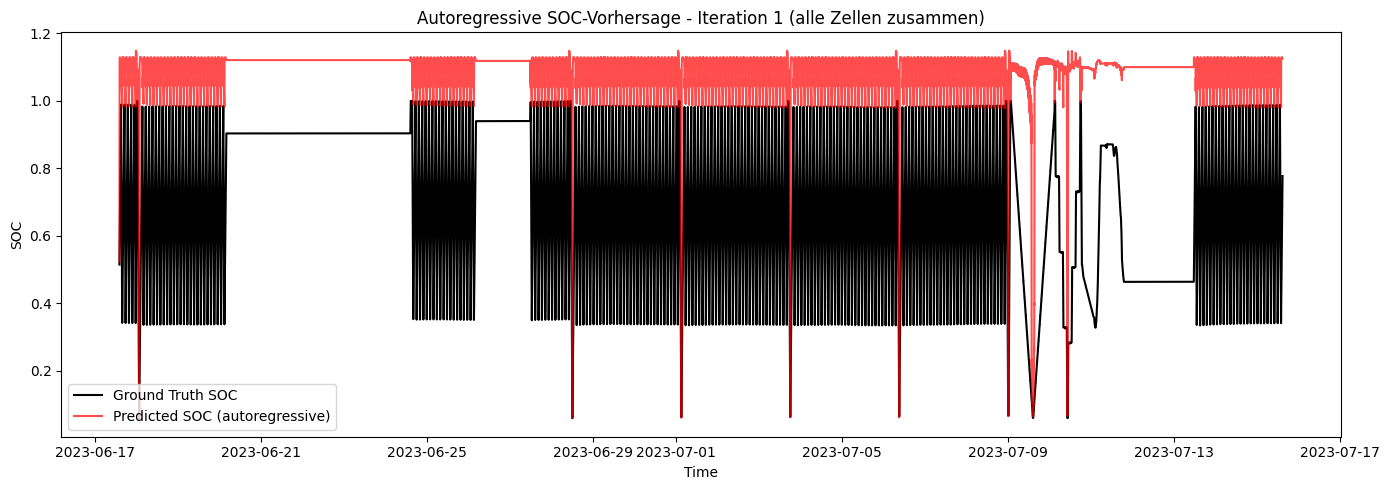


=== Iteration 2/5 ===
  Epoch [1/5] - Train MSE: 0.0000
  Epoch [2/5] - Train MSE: 0.0000
  Epoch [3/5] - Train MSE: 0.0000
  Epoch [4/5] - Train MSE: 0.0000
  Epoch [5/5] - Train MSE: 0.0000
Modell gespeichert: models/LSTM/lstm_soc_model_trained.pth


/tmp/ipykernel_16262/4109224818.py:248: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_16262/4109224818.py:252: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_name)


Plot gespeichert unter: models/LSTM/model_iterativ_2.png


/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


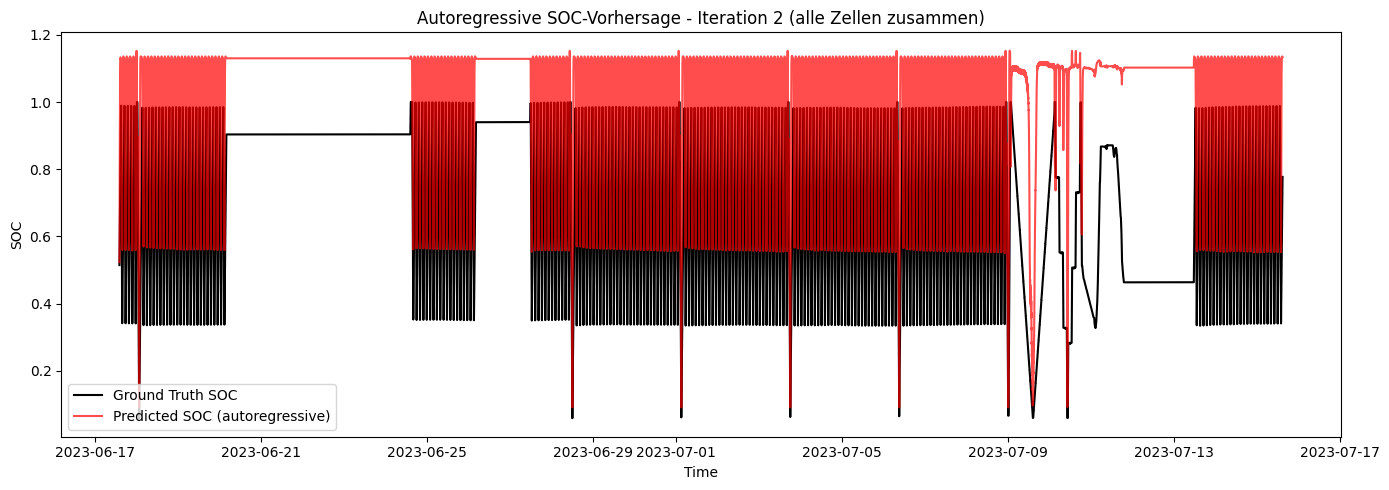


=== Iteration 3/5 ===
  Epoch [1/5] - Train MSE: 0.0000
  Epoch [2/5] - Train MSE: 0.0000
  Epoch [3/5] - Train MSE: 0.0000
  Epoch [4/5] - Train MSE: 0.0000
  Epoch [5/5] - Train MSE: 0.0000
Modell gespeichert: models/LSTM/lstm_soc_model_trained.pth


/tmp/ipykernel_16262/4109224818.py:248: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_16262/4109224818.py:252: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_name)


Plot gespeichert unter: models/LSTM/model_iterativ_3.png


/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


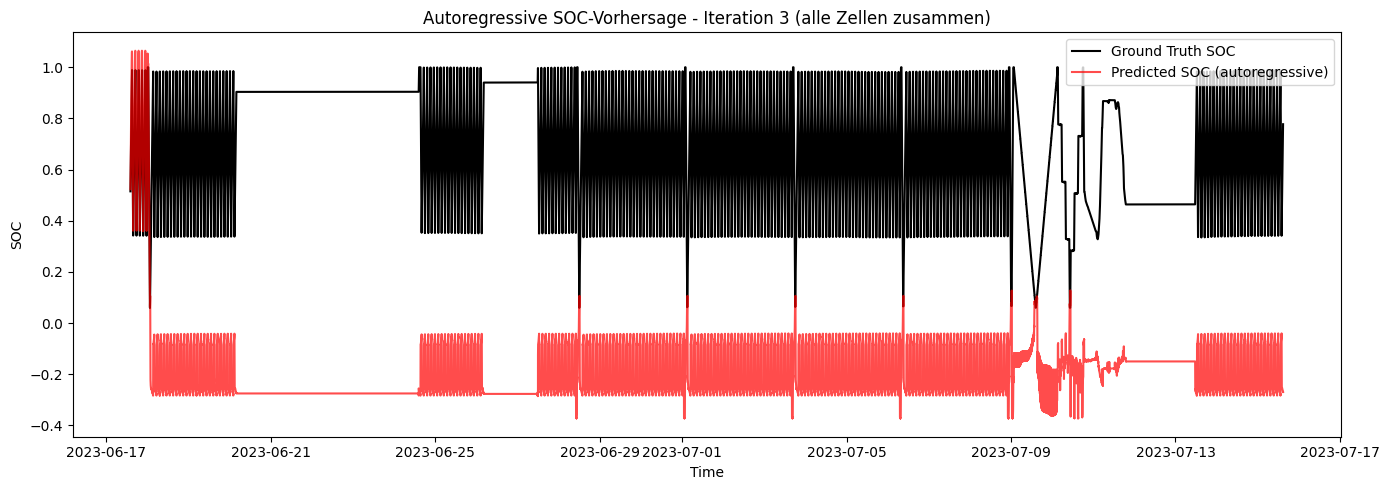


=== Iteration 4/5 ===
  Epoch [1/5] - Train MSE: 0.0000
  Epoch [2/5] - Train MSE: 0.0000
  Epoch [3/5] - Train MSE: 0.0000
  Epoch [4/5] - Train MSE: 0.0000
  Epoch [5/5] - Train MSE: 0.0000
Modell gespeichert: models/LSTM/lstm_soc_model_trained.pth


/tmp/ipykernel_16262/4109224818.py:248: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_16262/4109224818.py:252: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_name)


Plot gespeichert unter: models/LSTM/model_iterativ_4.png


/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


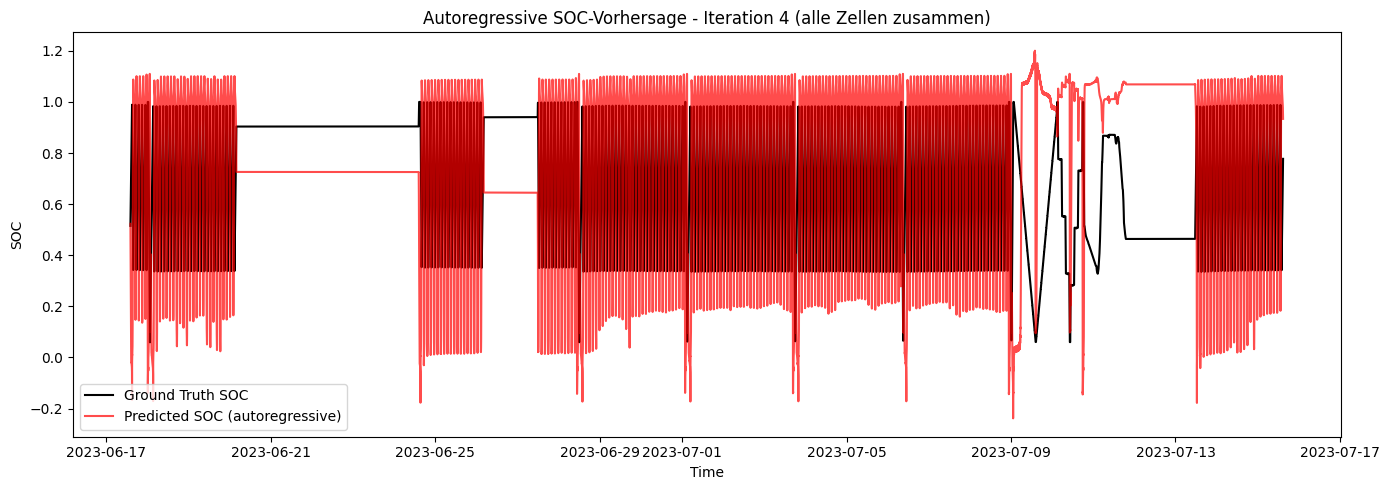


=== Iteration 5/5 ===
  Epoch [1/5] - Train MSE: 0.0000
  Epoch [2/5] - Train MSE: 0.0000
  Epoch [3/5] - Train MSE: 0.0000
  Epoch [4/5] - Train MSE: 0.0000
  Epoch [5/5] - Train MSE: 0.0000
Modell gespeichert: models/LSTM/lstm_soc_model_trained.pth


/tmp/ipykernel_16262/4109224818.py:248: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_16262/4109224818.py:252: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_name)


Plot gespeichert unter: models/LSTM/model_iterativ_5.png


/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


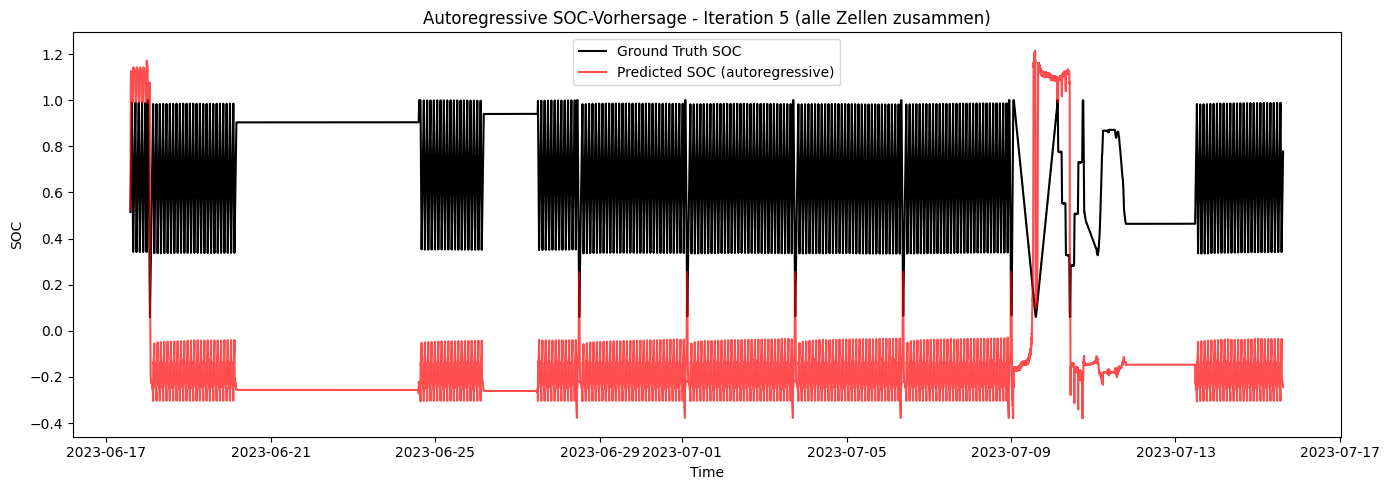

Iteratives Training abgeschlossen.


In [3]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

###############################################################################
# 1) Laden der Daten
###############################################################################

def load_all_cell_data(data_dir: Path):
    """
    Durchsucht das Verzeichnis `data_dir` nach allen Unterordnern,
    die mit 'MGFarm_18650_C' beginnen. In jedem solchen Ordner wird
    die Datei 'df.parquet' eingelesen (falls vorhanden).

    Gibt ein Dict zurück:
      {
         "C01": DataFrame,  # aus Ordner MGFarm_18650_C01
         "C02": DataFrame,  # aus Ordner MGFarm_18650_C02
         ...
      }
    """
    dataframes = {}
    for folder in data_dir.iterdir():
        if folder.is_dir() and folder.name.startswith("MGFarm_18650_C"):
            # Beispiel: Ordnername "MGFarm_18650_C01" -> Zellname: "C01"
            cell_name = folder.name.replace("MGFarm_18650_", "")
            df_path = folder / 'df.parquet'
            if df_path.exists():
                df = pd.read_parquet(df_path)
                dataframes[cell_name] = df
                print(f"Loaded: {folder.name} -> Key: {cell_name}")
            else:
                print(f"Warning: No df.parquet found in {folder.name}")
    return dataframes

data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_all_cell_data(data_dir)

if not cell_data:
    raise ValueError("Keine Zellen gefunden; bitte prüfen, ob Unterordner vorhanden sind.")

# Alle DataFrames zu einem großen kombinieren:
# z.B. df_full = pd.concat(list(cell_data.values()), ignore_index=True)
# Fürs Debuggen / Testen kann man auch nur einen Teil nehmen.
df_full = pd.concat(cell_data.values(), ignore_index=True)
print("Anzahl Zeilen (alle Zellen kombiniert):", len(df_full))

# Wir definieren wieder ein "Test-Fenster" (df_test) in der Mitte:
sample_size = int(len(df_full) * 0.01)  # 1% für Test (zum Beispiel)
mid_start = (len(df_full) - sample_size) // 2
df_test = df_full.iloc[mid_start : mid_start + sample_size].copy()

# Timestamp in Datetime umwandeln
df_test.loc[:, 'timestamp'] = pd.to_datetime(df_test['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_test_orig = df_test.copy()

print(f"Test-Datensatz-Größe (konstant): {len(df_test)}")


###############################################################################
# 2) Vorbereitung: Funktion, um aus df_test_orig jeweils 
#    ein (Train+Val)-Set via Zufall zu ziehen & zu skalieren
###############################################################################
def create_train_val_split_from_test(df_test_orig, frac=0.8, random_state=None):
    """
    Ziehe zufällig einen Teil aus df_test_orig, 
    splitte in 80% (train) und 20% (val),
    skaliere Voltage/Current.
    """
    # 1) Einen Teil ziehen (z.B. 80% von df_test_orig)
    n_samples = int(len(df_test_orig) * frac)
    df_train_val = df_test_orig.sample(n=n_samples, replace=False, random_state=random_state).copy()

    # 2) 80/20 in train/val
    total = len(df_train_val)
    cut = int(total * 0.8)

    # Optional sortieren nach Index, damit die Reihenfolge zeitlich konsistent ist
    df_train_val_sorted = df_train_val.sort_index()
    train_data_orig = df_train_val_sorted.iloc[:cut].copy()
    val_data_orig   = df_train_val_sorted.iloc[cut:].copy()

    # 3) Skalierung (nur Voltage & Current)
    scaler = StandardScaler()
    features = ['Voltage[V]', 'Current[A]']

    train_data = train_data_orig.copy()
    val_data   = val_data_orig.copy()

    train_data[features] = scaler.fit_transform(train_data[features])
    val_data[features]   = scaler.transform(val_data[features])

    return train_data, val_data, scaler


###############################################################################
# 3) Dataset-Klasse und Modell (LSTM)
###############################################################################

class SequenceDataset(Dataset):
    """
    Gibt (seq, next_value) zurück, d.h. 
      X[t] = (Voltage[t], Current[t], SOC[t])  (über seq_length Timesteps)
      y[t] = SOC[t+1].
    """
    def __init__(self, data_array, seq_len=60):
        self.data_array = data_array
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data_array) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.data_array[idx : idx + self.seq_len]  # shape (seq_len, 3)
        y_val = self.data_array[idx + self.seq_len, 2]     # Spalte 2 = SOC
        x_seq_t = torch.tensor(x_seq, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32)
        return x_seq_t, y_val_t

class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x.shape = (batch_size, seq_length, input_size=3)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # letzter Zeitschritt im Output:
        last_out = lstm_out[:, -1, :]  # shape = (batch_size, hidden_size)
        soc_pred = self.fc(last_out)   # shape = (batch_size, 1)
        return soc_pred.squeeze(-1)    # -> (batch_size,)

def predict_autoregressive(model, data_array, seq_len=60):
    """
    Autoregressive Vorhersage:
    Nutzt das erste seq_len-Fenster mit echten SOC-Werten,
    ab Schritt seq_len wird SOC[t+1] durch Modell ersetzt.
    """
    model.eval()
    data_clone = data_array.copy()
    preds = np.full(len(data_clone), np.nan)

    with torch.no_grad():
        for i in range(seq_len, len(data_clone)):
            input_seq = data_clone[i-seq_len : i]  # (seq_len, 3)
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # shape (1, seq_len, 3)
            
            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            # Autoregressiv: SOC-Spalte überschreiben
            data_clone[i, 2] = pred_soc

    return preds


###############################################################################
# 4) Hauptteil: Modell anlegen und iterativ trainieren
###############################################################################

# a) Initialisiere einmal das Modell und den Optimizer
model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

seq_length = 60
NUM_ITERATIONS = 5     # Wie oft wir das "iterative" Training wiederholen
EPOCHS_PER_ITER = 5    # Wie viele Epochen pro Iteration (klein für schnellen Test)

# (Optional) Ordner fürs Speichern
os.makedirs("models/LSTM", exist_ok=True)
model_save_path = "models/LSTM/lstm_soc_model_trained.pth"

for iteration in range(1, NUM_ITERATIONS+1):
    print(f"\n=== Iteration {iteration}/{NUM_ITERATIONS} ===")

    # 1) Erstelle Trainings- und Validierungs-Datensatz per Zufall aus df_test
    train_data, val_data, scaler = create_train_val_split_from_test(
        df_test_orig, 
        frac=0.8,            # z.B. 80% von df_test_orig als "Train+Val"
        random_state=None    # Keinen fixen Seed -> jedes Mal anderer Split
    )
    
    # 2) Kombiniere (Train + Val) zu einem DataFrame (fürs Training)
    df_trainval = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)
    
    # 3) Erstelle Numpy-Arrays: [Voltage, Current, SOC]
    trainval_array = df_trainval[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values
    
    # 4) Test-Daten für diese Iteration: 
    #    Voltage/Current skalieren mit dem frisch gelernten Scaler
    df_test_scaled = df_test.copy()
    df_test_scaled[['Voltage[V]', 'Current[A]']] = scaler.transform(
        df_test_scaled[['Voltage[V]', 'Current[A]']]
    )
    test_array = df_test_scaled[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values
    
    # 5) DataLoader für Training & Test
    trainval_dataset = SequenceDataset(trainval_array, seq_len=seq_length)
    trainval_loader = DataLoader(trainval_dataset, batch_size=32, shuffle=True)
    
    test_dataset = SequenceDataset(test_array, seq_len=seq_length)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 6) Training auf diesem (zufällig gezogenen) Datensatz
    model.train()
    for epoch in range(1, EPOCHS_PER_ITER+1):
        train_losses = []
        for x_batch, y_batch in trainval_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        print(f"  Epoch [{epoch}/{EPOCHS_PER_ITER}] - Train MSE: {np.mean(train_losses):.4f}")
    
    # 7) Zwischendurch speichern
    torch.save(model.state_dict(), model_save_path)
    print(f"Modell gespeichert: {model_save_path}")
    
    # 8) Testen + Plotten
    preds_test = predict_autoregressive(model, test_array, seq_len=seq_length)
    gt_test = df_test_orig["SOC_ZHU"].values  # Ground Truth SOC unskaliert
    time_test = df_test_orig['timestamp'].values
    
    plt.figure(figsize=(14, 5))
    plt.plot(time_test, gt_test, label="Ground Truth SOC", color='k')
    plt.plot(time_test, preds_test, label="Predicted SOC (autoregressive)", color='r', alpha=0.7)
    plt.title(f"Autoregressive SOC-Vorhersage - Iteration {iteration} (alle Zellen zusammen)")
    plt.xlabel("Time")
    plt.ylabel("SOC")
    plt.legend()
    plt.tight_layout()

    # Plot speichern
    save_name = f"models/LSTM/model_iterativ_{iteration}.png"
    plt.savefig(save_name)
    print(f"Plot gespeichert unter: {save_name}")
    plt.show()
    # plt.close()  # Falls du kein Popup möchtest, stattdessen plt.close()

print("Iteratives Training abgeschlossen.")


# nur Scaling plotten

In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler

###############################################################################
# 1) Laden der Daten
###############################################################################

def load_all_cell_data(data_dir: Path):
    """
    Durchsucht das Verzeichnis `data_dir` nach allen Unterordnern,
    die mit 'MGFarm_18650_C' beginnen. In jedem solchen Ordner wird
    die Datei 'df.parquet' eingelesen (falls vorhanden).

    Gibt ein Dict zurück:
      {
         "C01": DataFrame,  # aus Ordner MGFarm_18650_C01
         "C02": DataFrame,  # aus Ordner MGFarm_18650_C02
         ...
      }
    """
    dataframes = {}
    for folder in data_dir.iterdir():
        if folder.is_dir() and folder.name.startswith("MGFarm_18650_C"):
            cell_name = folder.name.replace("MGFarm_18650_", "")  # z.B. "C01"
            df_path = folder / 'df.parquet'
            if df_path.exists():
                df = pd.read_parquet(df_path)
                dataframes[cell_name] = df
                print(f"Loaded: {folder.name} -> Key: {cell_name}")
            else:
                print(f"Warning: No df.parquet found in {folder.name}")
    return dataframes

# Pfad anpassen
data_dir = Path("/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes")
cell_data = load_all_cell_data(data_dir)

if not cell_data:
    raise ValueError("Keine Zellen gefunden; bitte prüfen, ob Unterordner vorhanden sind.")

###############################################################################
# 2) Skalieren von Voltage und Current für jede Zelle
###############################################################################

# Wir erstellen einen Dictionary, in dem wir die "scaled" DataFrames ablegen
scaled_cell_data = {}

# Wir plotten nachher für alle Zellen in einem Diagramm
# Deswegen sammeln wir die Farben in einer Liste (falls du mehr Zellen hast,
# kannst du mehr Farben definieren oder automatisch generieren).
import matplotlib.colors as mcolors
color_list = list(mcolors.TABLEAU_COLORS.values())  # 10 Standard-Farben

# Features, die wir skalieren wollen
features_to_scale = ["Voltage[V]", "Current[A]"]

for i, (cell_name, df) in enumerate(cell_data.items()):
    # Kopie des DF anlegen, um Original nicht zu verändern
    df_scaled = df.copy()
    
    # Timestamp konvertieren, falls noch nicht geschehen
    # (Manche df.parquet haben evtl. die Spalte schon konvertiert)
    if "Absolute_Time[yyyy-mm-dd hh:mm:ss]" in df_scaled.columns:
        df_scaled["timestamp"] = pd.to_datetime(df_scaled["Absolute_Time[yyyy-mm-dd hh:mm:ss]"])
    else:
        print(f"Warnung: Zeitspalte fehlt in {cell_name} - kann nicht konvertieren")
        df_scaled["timestamp"] = pd.NaT  # oder einfach leer

    df_scaled.sort_values(by="timestamp", inplace=True)  # Zeitlich sortieren
    
    # Nur skalieren, wenn Spalten existieren
    missing_cols = [col for col in features_to_scale if col not in df_scaled.columns]
    if missing_cols:
        print(f"Warnung: Zelle {cell_name} fehlt Spalten {missing_cols} - Skalierung wird übersprungen!")
        scaled_cell_data[cell_name] = df_scaled
        continue
    
    # Scaler anlegen und fitten auf Voltage & Current
    scaler = StandardScaler()
    df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
    
    # df_scaled hat nun die skalierten Spalten
    scaled_cell_data[cell_name] = df_scaled

###############################################################################
# 3) Plotten: SOC, Voltage und Current (jeweils mit allen Zellen)
###############################################################################

# Lege Figure + 3 Subplots an
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=False)
ax_voltage, ax_soc, ax_current = axes

# Plot-Index für Farben
idx_color = 0

# Gehe alle Zellen durch und plotte
for cell_name, df_scaled in scaled_cell_data.items():
    # Falls kein timestamp vorhanden, skip
    if "timestamp" not in df_scaled.columns:
        print(f"Kein 'timestamp' in {cell_name}, wird nicht geplottet.")
        continue
    
    # Zeit, Voltage, Current, SOC (unskaliert?)
    time_data = df_scaled["timestamp"].values
    # Wir nehmen die (evtl.) skalierten Voltage/Current-Spalten
    # SOC bleibt unskaliert, falls es existiert
    voltage_data = df_scaled["Voltage[V]"].values if "Voltage[V]" in df_scaled.columns else None
    current_data = df_scaled["Current[A]"].values if "Current[A]" in df_scaled.columns else None
    soc_data     = df_scaled["SOC_ZHU"].values      if "SOC_ZHU" in df_scaled.columns else None
    
    color = color_list[idx_color % len(color_list)]
    idx_color += 1
    
    # Voltage
    if voltage_data is not None:
        ax_voltage.plot(time_data, voltage_data, label=f"{cell_name}", color=color, alpha=0.8)
    
    # SOC (Falls Spalte existiert)
    if soc_data is not None:
        ax_soc.plot(time_data, soc_data, label=f"{cell_name}", color=color, alpha=0.8)
    
    # Current
    if current_data is not None:
        ax_current.plot(time_data, current_data, label=f"{cell_name}", color=color, alpha=0.8)

ax_voltage.set_title("Voltage (skaliert) - alle Zellen")
ax_voltage.set_xlabel("Time")
ax_voltage.set_ylabel("Scaled Voltage[V]")
ax_voltage.legend(loc="best")

ax_soc.set_title("SOC (unskaliert) - alle Zellen")
ax_soc.set_xlabel("Time")
ax_soc.set_ylabel("SOC_ZHU")
ax_soc.legend(loc="best")

ax_current.set_title("Current (skaliert) - alle Zellen")
ax_current.set_xlabel("Time")
ax_current.set_ylabel("Scaled Current[A]")
ax_current.legend(loc="best")

plt.tight_layout()
plt.show()



Loaded: MGFarm_18650_C21 -> Key: C21
Loaded: MGFarm_18650_C11 -> Key: C11
Loaded: MGFarm_18650_C07 -> Key: C07
Loaded: MGFarm_18650_C25 -> Key: C25
Loaded: MGFarm_18650_C29 -> Key: C29
Loaded: MGFarm_18650_C19 -> Key: C19
Loaded: MGFarm_18650_C15 -> Key: C15
Loaded: MGFarm_18650_C03 -> Key: C03
Loaded: MGFarm_18650_C27 -> Key: C27
Loaded: MGFarm_18650_C13 -> Key: C13
Loaded: MGFarm_18650_C17 -> Key: C17
Loaded: MGFarm_18650_C01 -> Key: C01
Loaded: MGFarm_18650_C09 -> Key: C09
Loaded: MGFarm_18650_C05 -> Key: C05
Loaded: MGFarm_18650_C23 -> Key: C23


: 